In [ ]:
%%shell
jupyter nbconvert --to html '/content/MIE1624_GROUP19_GROUPPROJECT.ipynb'

[NbConvertApp] Converting notebook /content/MIE1624_GROUP19_GROUPPROJECT.ipynb to html
[NbConvertApp] Writing 2191661 bytes to /content/MIE1624_GROUP19_GROUPPROJECT.html


# Part 1 . Data Preprocessing, feature engineer, EDA and model tuning

## Part 1.0 import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic package to handle data.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dpd
from collections import Counter

In [ ]:
# import sentiment_analysis.csv as df_sa
df_sa = pd.read_csv('/content/drive/MyDrive/1624/data/sentiment_analysis.csv',low_memory=False)
print("Shape of sentiment_analysis.csv: ",df_sa.shape)
# 0 stands for negative and 1 stands for positive
# ID is useless in this sentiment analysis, so we drop this column
df_sa = df_sa[['text','label']]
print("Revised Shape of sentiment_analysis.csv: ",df_sa.shape)
df_sa.tail()

Shape of sentiment_analysis.csv:  (550391, 3)
Revised Shape of sentiment_analysis.csv:  (550391, 2)


,text,label
550386,@goddesses_o I can't stop watching her...mm. M...,0
550387,Poor old Tom Odell doesn't look like he would ...,0
550388,#antsmasher I smashed 7 ants in this awesome ...,1
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1
550390,Bixbeat Mixtape Vol.2 is here with great artis...,1


## Part 1.1 preprocess

In [ ]:
import re
import html
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [ ]:
def textprocess(text):
  ## Convert html element like &amp to character
  text=html.unescape(text)
  ## ignores the characters that cannot be encoded like emoji
  text=text.encode('ascii','ignore').decode()
  ## Pattern expression to filter no english elements, some word,character irrevelant .
  ## Pattern expression to filter URL
  ## Text to lowercase by lower()
  ## Remove the  html tags and attributes (i.e., /<[^>]+>/)  by pattern '<[^>]+>'
  ## Just remove the # tag and keep the word after # tag
  text=re.sub(r'&\w*|#|@|https?:\S+|http?:\S|[^a-z]+|rt|<[^>]+>', ' ', str(text).lower())
  words=[]
  for word in word_tokenize(text):
    ## Remove stop word
    if word not in stop_words: 
      ## Stem the word
     words.append(lemmatizer.lemmatize(word))
  text=' '.join(words)
  return text

In [ ]:
## Process the text
df_sa.text=df_sa.text.apply(lambda x: textprocess(x))

In [ ]:
df_sa.head()

,text,label
0,josh jenkins looking forward tab breeder crown...,1
1,mianusmanjaved congratulation pakistan becomin...,1
2,pepale september yesmag taking maine mendozas ...,1
3,david gaibis newly painted wall thanks million...,1
4,cedricfeschotte excited announce july feschott...,1


In [ ]:
pd.isnull(df_sa.label).sum()

0

## Part 1.2 EDA

Text(0.5, 1.0, 'Dataset labels distribuition')

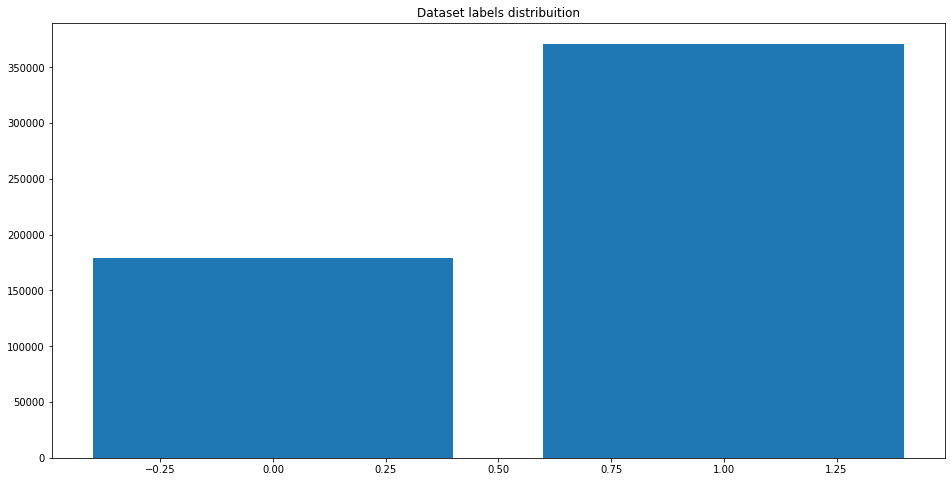

In [ ]:
## The total distribution of label
label_sa=Counter(df_sa.label)
plt.figure(figsize=(16,8))
plt.bar(label_sa.keys(), label_sa.values())
plt.title("Dataset labels distribuition")

In [ ]:
## Bar plot
##  The distribution of label with different party
## The total distribution of label
temp = df_sa.groupby('label').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues')

,label,text
1,1,371341
0,0,179050


In [ ]:
## Funnel diagram for sa dataset
fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.text,
    title = {"position": "top center", "text": "Label Distribution"}
    ))
fig.show()

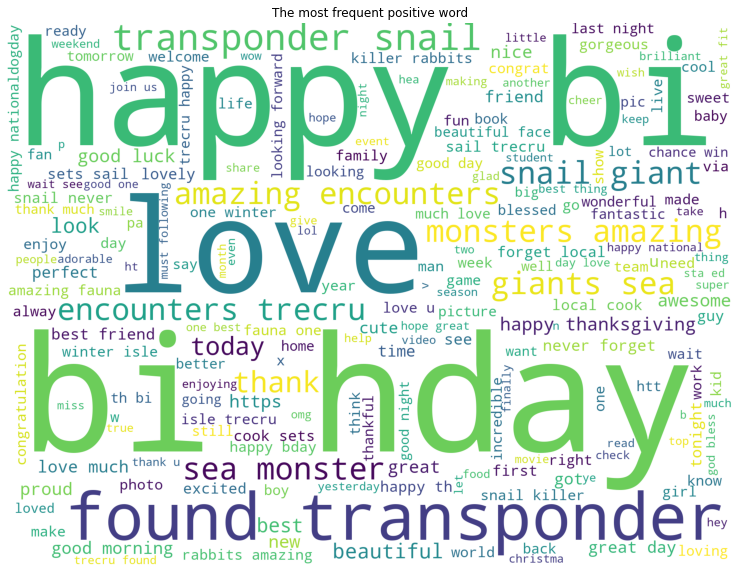

In [ ]:
## Wordcloud diagram for sentiment with positive
dic_ca_pos=defaultdict(int)
df_sa_pos=df_sa[df_sa.label==1]
word=' '.join(df_sa_pos.text)
wc=WordCloud(background_color='white',width=2000, height=1500).generate(word)
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.title('The most frequent positive word')
plt.axis('off')
plt.show()

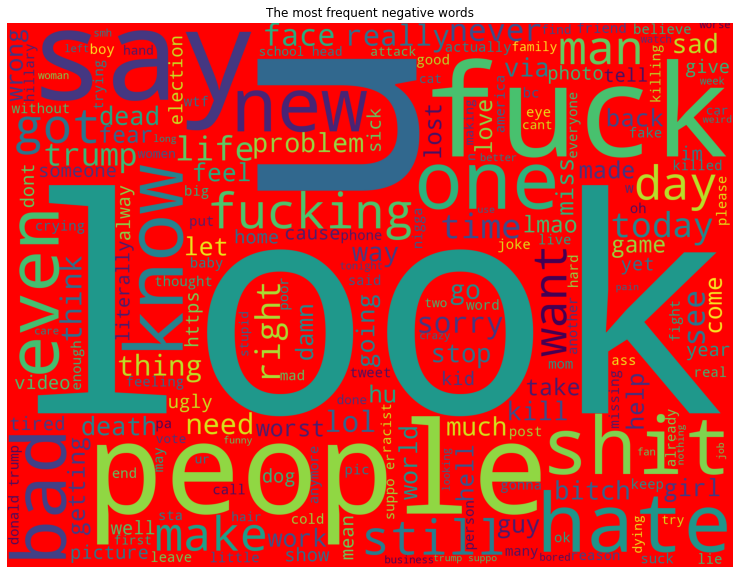

In [ ]:
## Wordcloud diagram for sentiment with negative
dic_ca_neg=defaultdict(int)
df_sa_neg=df_sa[df_sa.label==0]
word=' '.join(df_sa_neg.text)
wc=WordCloud(background_color='red',width=2000, height=1500).generate(word)
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.title('The most frequent negative words')
plt.axis('off')
plt.show()

## Part 1.3 Word to vector

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [ ]:
def word2bow(train,test):
  vectorizer = CountVectorizer(max_features=6000)
  train_bow=vectorizer.fit_transform(train.text)
  test_bow=vectorizer.transform(test.text)
  return vectorizer, train_bow, test_bow
def word2tfidf(train, test):
  tfidf_vectorizer = TfidfVectorizer(max_features=6000)
  train_tfidf = tfidf_vectorizer.fit_transform(train.text)
  test_tfidf = tfidf_vectorizer.transform(test.text)
  return tfidf_vectorizer, train_tfidf, test_tfidf

In [ ]:
## for sentiment dataset
## for sentiment dataset
## Split first then vectorize prevent target leakage
df_train_sa, df_test_sa = 0, 0
df_train_sa, df_test_sa = train_test_split(df_sa,test_size=0.25,random_state=40)

y_train_sa=df_train_sa.label
y_test_sa=df_test_sa.label

# Bag of word for sa
bow_vectorizer_sa, X_train_bow_sa, X_test_bow_sa=word2bow(df_train_sa, df_test_sa)

# TF- IDF for sa
tfidf_vectorizer_sa,X_train_tfidf_sa, X_test_tfidf_sa= word2tfidf(df_train_sa, df_test_sa)

In [ ]:
feature_names = bow_vectorizer_sa.get_feature_names() 
#get bow vector for first document 
first_document_vector=X_train_bow_sa[0] 
#print the scores 
df = pd.DataFrame(first_document_vector.T.toarray(), index=feature_names, columns=["Bow"]) 
df.sort_values(by=["Bow"],ascending=False)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Bow
chanyeol,1
hday,1
love,1
bi,1
park,1
...,...
firework,0
fired,0
fire,0
fintech,0


In [ ]:
# ## Sample for tfidf
feature_names = tfidf_vectorizer_sa.get_feature_names() 
#get tfidf vector for first document 
first_document_vector=X_train_tfidf_sa[0] 
#print the scores 
df = pd.DataFrame(first_document_vector.T.toarray(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
chanyeol,0.660659
park,0.519168
hday,0.298409
bi,0.296424
happy,0.243608
...,...
firework,0.000000
fired,0.000000
fire,0.000000
fintech,0.000000


## Part 1.4 Model tuning 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC    
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
## logit
%%time
model=LogisticRegression()
param_grid ={
     'penalty':['l2'],
     'C':[0.01,0.1,1,10]
     }

## BOW
clf1 = GridSearchCV(model,cv=2, param_grid = param_grid, refit=True, scoring='accuracy')
best_clf1_bow=clf1.fit(X_train_bow_sa,y_train_sa)
y_pred_bow_sa=best_clf1_bow.predict(X_test_bow_sa)
score1=accuracy_score(y_test_sa,y_pred_bow_sa)

## TFIDF
clf2 = GridSearchCV(model,cv=2, param_grid = param_grid, refit=True, scoring='accuracy')
best_clf1_tfidf=clf2.fit(X_train_tfidf_sa,y_train_sa)
y_pred_tfidf=best_clf1_tfidf.predict(X_test_tfidf_sa)
score2=accuracy_score(y_test_sa,y_pred_tfidf)

print(' Results from Grid Search ')
print('Result for bag of word')
print('\n The best score across ALL searched params:\n',best_clf1_bow.best_score_)
print('\n The best parameters across ALL searched params:\n',best_clf1_bow.best_params_)
print('\n The accuracy on test set:\n',score1)

print('Result for TF-IDF')
print("\n The best score across ALL searched params:\n",best_clf1_tfidf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf1_tfidf.best_params_)
print('\n The accuracy on test set:\n',score2)


 Results from Grid Search 
Result for bag of word

 The best score across ALL searched params:
 0.9656244168340327

 The best parameters across ALL searched params:
 {'C': 1, 'penalty': 'l2'}

 The accuracy on test set:
 0.9672524309946365
Result for TF-IDF

 The best score across ALL searched params:
 0.9654717979728168

 The best parameters across ALL searched params:
 {'C': 10, 'penalty': 'l2'}

 The accuracy on test set:
 0.9674704574194393
CPU times: user 48.8 s, sys: 570 ms, total: 49.4 s
Wall time: 49.2 s


In [ ]:
## KNN
%%time
model=KNeighborsClassifier(n_neighbors=2,n_jobs=-1) 
param_grid={
    'n_neighbors':[2,5,8],
 }
## BOW
clf1=GridSearchCV(model,cv=2, param_grid = param_grid, refit=True, scoring='accuracy')
best_clf2_bow = clf1.fit(X_train_bow_sa,y_train_sa)
y_pred_bow=best_clf2_bow.predict(X_test_bow_sa)
score1=accuracy_score(y_test_sa,y_pred_bow)

## TFIDF
clf2=GridSearchCV(model,cv=2, param_grid = param_grid, refit=True, scoring='accuracy')
best_clf2_tfidf = clf2.fit(X_train_tfidf_sa,y_train_sa)
y_pred_tfidf=best_clf2_tfidf.predict(X_test_tfidf_sa)
score2=accuracy_score(y_test_sa,y_pred_tfidf)

print(" Results from Grid Search ")
print('Result for bow')
print("\n The best score across ALL searched params:\n",best_clf2_bow.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf2_bow.best_params_)
print('\n The accuracy on test set:\n',score1)

print('Result for tfidf')
print("\n The best score across ALL searched params:\n",best_clf2_tfidf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf2_tfidf.best_params_)
print('\n The accuracy on test set:\n',score2)


 Results from Grid Search 
Result for bow

 The best score across ALL searched params:
 0.9156332597656511

 The best parameters across ALL searched params:
 {'n_neighbors': 5}

 The accuracy on test set:
 0.9229058561897702
Result for tfidf

 The best score across ALL searched params:
 0.7446953325671569

 The best parameters across ALL searched params:
 {'n_neighbors': 2}

 The accuracy on test set:
 0.7980711928952455
CPU times: user 6h 30min 41s, sys: 4min 10s, total: 6h 34min 52s
Wall time: 5h 4min 15s


In [ ]:
## LinerSVC
%%time
model=LinearSVC()
param_grid=   {  'penalty':['l2'],
            'C':[0.1,1,10],
      }
## BOW
clf1 = GridSearchCV(model,cv=2, param_grid = param_grid, refit=True, scoring='accuracy')
best_clf3_bow=clf1.fit(X_train_bow_sa,y_train_sa)
y_pred_bow=best_clf3_bow.predict(X_test_bow_sa)
score1=accuracy_score(y_test_sa,y_pred_bow)
## TDIDF
clf2 = GridSearchCV(model,cv=2, param_grid = param_grid, refit=True, scoring='accuracy')
best_clf3_tfidf=clf2.fit(X_train_tfidf_sa,y_train_sa)
y_pred_tfidf=best_clf3_tfidf.predict(X_test_tfidf_sa)
score2=accuracy_score(y_test_sa,y_pred_tfidf)

print(" Results from Grid Search ")
print('Result for bag of word')
print("\n The best score across ALL searched params:\n",best_clf3_bow.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf3_bow.best_params_)
print('\n The accuracy on test set:\n',score1)

print('Result for TF-IDF')
print("\n The best score across ALL searched params:\n",best_clf3_tfidf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf3_tfidf.best_params_)
print('\n The accuracy on test set:\n',score2)

 Results from Grid Search 
Result for bag of word

 The best score across ALL searched params:
 0.9653143343264204

 The best parameters across ALL searched params:
 {'C': 0.1, 'penalty': 'l2'}

 The accuracy on test set:
 0.9668599834299917
Result for TF-IDF

 The best score across ALL searched params:
 0.9652174331884742

 The best parameters across ALL searched params:
 {'C': 1, 'penalty': 'l2'}

 The accuracy on test set:
 0.9671216151397549
CPU times: user 1min 25s, sys: 366 ms, total: 1min 26s
Wall time: 1min 26s


In [ ]:
## DTF
%%time
model=DecisionTreeClassifier()
param_grid={
      'criterion':['gini','entropy'],
     'max_depth':[3,6,10],
     'min_samples_leaf':[2,5,8,10,15]
}
## BOW
clf = RandomizedSearchCV(model,cv=2, param_distributions = param_grid, refit=True, scoring='accuracy')
best_clf4_bow=clf.fit(X_train_bow_sa,y_train_sa)
y_pred_bow=best_clf4_bow.predict(X_test_bow_sa)
score1=accuracy_score(y_test_sa,y_pred_bow)

## TFIDF
clf1 = RandomizedSearchCV(model,cv=2, param_distributions = param_grid, refit=True, scoring='accuracy')
best_clf4_tfidf=clf1.fit(X_train_tfidf_sa,y_train_sa)
y_pred_tfidf=best_clf4_tfidf.predict(X_test_tfidf_sa)
score2=accuracy_score(y_test_sa,y_pred_tfidf)

print(" Results from Grid Search ")
print('Result for bag of word')
print("\n The best score across ALL searched params:\n",best_clf4_bow.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf4_bow.best_params_)
print('\n The accuracy on test set:\n',score1)

print('Result for TF-IDF')
print("\n The best score across ALL searched params:\n",best_clf4_tfidf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf4_tfidf.best_params_)
print('\n The accuracy on test set:\n',score2)


 Results from Grid Search 
Result for bag of word

 The best score across ALL searched params:
 0.7342251438858933

 The best parameters across ALL searched params:
 {'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}

 The accuracy on test set:
 0.7342621259029928
Result for TF-IDF

 The best score across ALL searched params:
 0.7339271740513347

 The best parameters across ALL searched params:
 {'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}

 The accuracy on test set:
 0.7340804372156572
CPU times: user 46.3 s, sys: 202 ms, total: 46.5 s
Wall time: 46.3 s


In [ ]:
## MultinomialNB
%%time
model= MultinomialNB()
## BOW
clf = GridSearchCV(model,cv=2, param_grid={}, refit=True, scoring='accuracy')
best_clf5_bow=clf.fit(X_train_bow_sa,y_train_sa)
y_pred_bow=best_clf5_bow.predict(X_test_bow_sa)
score1=accuracy_score(y_test_sa,y_pred_bow)

## TFIDF
clf1 = GridSearchCV(model,cv=2, param_grid={}, refit=True, scoring='accuracy')
best_clf5_tfidf=clf1.fit(X_train_tfidf_sa,y_train_sa)
y_pred_tfidf=best_clf5_tfidf.predict(X_test_tfidf_sa)
score2=accuracy_score(y_test_sa,y_pred_tfidf)

print(" Results from Grid Search ")
print('Result for bag of word')
print("\n The best score across ALL searched params:\n",best_clf5_bow.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf5_bow.best_params_)
print('\n The accuracy on test set:\n',score1)
print('Result for TF-IDF')
print("\n The best score across ALL searched params:\n",best_clf5_tfidf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf5_tfidf.best_params_)
print('\n The accuracy on test set:\n',score2)

 Results from Grid Search 
Result for bag of word

 The best score across ALL searched params:
 0.9400692372367461

 The best parameters across ALL searched params:
 {}

 The accuracy on test set:
 0.9398101716594718
Result for TF-IDF

 The best score across ALL searched params:
 0.9264231713811363

 The best parameters across ALL searched params:
 {}

 The accuracy on test set:
 0.9264887571040277
CPU times: user 733 ms, sys: 13 ms, total: 746 ms
Wall time: 741 ms


In [ ]:
## RFC
%%time
model=RandomForestClassifier()
param_grid={
     'max_depth':[5,10],    
     'n_estimators': [100,300],
}
## BOW
clf = RandomizedSearchCV(model,cv=2, param_distributions = param_grid, refit=True, scoring='accuracy')
best_clf6_bow=clf.fit(X_train_bow_sa,y_train_sa)
y_pred_bow=best_clf6_bow.predict(X_test_bow_sa)
score1=accuracy_score(y_test_sa,y_pred_bow)

## TFIDF
clf1 = GridSearchCV(model,cv=2, param_grid=param_grid, refit=True, scoring='accuracy')
best_clf6_tfidf=clf1.fit(X_train_tfidf_sa,y_train_sa)
y_pred_tfidf=best_clf6_tfidf.predict(X_test_tfidf_sa)
score2=accuracy_score(y_test_sa,y_pred_tfidf)

print(" Results from Grid Search ")
print('Result for bag of word')
print("\n The best score across ALL searched params:\n",best_clf6_bow.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf6_bow.best_params_)
print('\n The accuracy on test set:\n',score1)

print('Result for TF-IDF')
print("\n The best score across ALL searched params:\n",best_clf6_tfidf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf6_tfidf.best_params_)
print('\n The accuracy on test set:\n',score2)

 Results from Grid Search 
Result for bag of word

 The best score across ALL searched params:
 0.6761694140215466

 The best parameters across ALL searched params:
 {'n_estimators': 100, 'max_depth': 10}

 The accuracy on test set:
 0.6744211398421489
Result for TF-IDF

 The best score across ALL searched params:
 0.6760216395816575

 The best parameters across ALL searched params:
 {'max_depth': 10, 'n_estimators': 100}

 The accuracy on test set:
 0.6745664907920174
CPU times: user 4min 27s, sys: 24.8 s, total: 4min 52s
Wall time: 4min 52s


In [ ]:
## XGB
%%time
model=XGBClassifier()
param_grid={
    #  'max_depth': [3, 10],
        'gamma': [0,0.1,0.5,1],
        # 'min_child_weight' : [3,5,7],
        'n_estimators': [100,300],
}
## BOW
clf = RandomizedSearchCV(model,cv=2, param_distributions = param_grid, refit=True, scoring='accuracy')
best_clf7_bow=clf.fit(X_train_bow_sa,y_train_sa)
y_pred_bow=best_clf7_bow.predict(X_test_bow_sa)
score1=accuracy_score(y_test_sa,y_pred_bow)
## TFIDF
clf1= RandomizedSearchCV(model,cv=2, param_distributions = param_grid, refit=True, scoring='accuracy')
best_clf7_tfidf=clf.fit(X_train_tfidf_sa,y_train_sa)
y_pred_tfidf=best_clf7_tfidf.predict(X_test_tfidf_sa)
score2=accuracy_score(y_test_sa,y_pred_tfidf)

print(" Results from Grid Search ")
print('Result for bag of word')
print("\n The best score across ALL searched params:\n",best_clf7_bow.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf7_bow.best_params_)
print('\n The accuracy on test set:\n',score1)
print('Result for TF-IDF')
print("\n The best score across ALL searched params:\n",best_clf7_tfidf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf7_tfidf.best_params_)
print('\n The accuracy on test set:\n',score2)

 Results from Grid Search 
Result for bag of word

 The best score across ALL searched params:
 0.8957976521115534

 The best parameters across ALL searched params:
 {'n_estimators': 300, 'gamma': 0.1}

 The accuracy on test set:
 0.896488321051178
Result for TF-IDF

 The best score across ALL searched params:
 0.8957976521115534

 The best parameters across ALL searched params:
 {'n_estimators': 300, 'gamma': 0.1}

 The accuracy on test set:
 0.8965973342635795
CPU times: user 20min 26s, sys: 2.53 s, total: 20min 28s
Wall time: 20min 26s


# Part 2 Sentiment classification on elon tweet and ukraine tweet

In [ ]:
## For echo drive
## Import elon tweet reply
elon_df=pd.read_csv('/content/drive/MyDrive/1624/data/tw_reply.csv',low_memory=False)
## Import Ukraine dataset
ukraine_2=pd.read_csv('/content/drive/MyDrive/1624/data/UkraineCombinedTweetsDeduped_FEB27.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,17])
ukraine_3=pd.read_csv('/content/drive/MyDrive/1624/data/UkraineCombinedTweetsDeduped_MAR27_to_28.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,17])
ukraine_4=pd.read_csv('/content/drive/MyDrive/1624/data/0427_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])
ukraine_5=pd.read_csv('/content/drive/MyDrive/1624/data/0527_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])
ukraine_6=pd.read_csv('/content/drive/MyDrive/1624/data/0627_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])
ukraine_7=pd.read_csv('/content/drive/MyDrive/1624/data/0727_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])
ukraine_8=pd.read_csv('/content/drive/MyDrive/1624/data/0827_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])
ukraine_9=pd.read_csv('/content/drive/MyDrive/1624/data/0927_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])
ukraine_10=pd.read_csv('/content/drive/MyDrive/1624/data/1027_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])
ukraine_11=pd.read_csv('/content/drive/MyDrive/1624/data/1127_UkraineCombinedTweetsDeduped.csv',low_memory=False,usecols=[1,4,6,11,12,14,16,28])

In [ ]:
## combine dataframe
ukraine_fulldf=pd.concat([ukraine_2,ukraine_3,ukraine_4,ukraine_5,ukraine_6,ukraine_7,ukraine_8,ukraine_9,ukraine_10,ukraine_11]).reset_index()

In [ ]:
## Preprocess
elon_df.text=elon_df.text.apply(lambda x:textprocess(x))
ukraine_fulldf.text=ukraine_fulldf.text.apply(lambda x:textprocess(x))

In [ ]:
## Vectorize
## elon
elon_bow=bow_vectorizer_sa.transform(elon_df.text)
elon_tfidf=tfidf_vectorizer_sa.transform(elon_df.text)
## ukraine
ukraine_bow=bow_vectorizer_sa.transform(ukraine_fulldf.text)
ukraine_tfidf=tfidf_vectorizer_sa.transform(ukraine_fulldf.text)

In [ ]:
## y_pred for elon
y_bow_elon=best_clf1_bow.predict(elon_bow)
y_tfidf_elon=best_clf1_tfidf.predict(elon_tfidf)
## y_pred for ukraine
y_bow_ukr=best_clf1_bow.predict(ukraine_bow)
y_tfidf_ukr=best_clf1_tfidf.predict(ukraine_tfidf)

In [ ]:
elon_df['Pred_BOW']=y_bow_elon
elon_df['Pred_TFIDF']=y_tfidf_elon

In [ ]:
ukraine_fulldf['Pred_bow']=y_bow_ukr
ukraine_fulldf['Pred_tfidf']=y_tfidf_ukr

In [ ]:
## Dataset for elson musk download from querqus
## Dataset for Ukraine download from https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war
elon_df=pd.read_csv('/content/drive/MyDrive/1624/data/elon_df.csv')
ukraine_fulldf=pd.read_csv('/content/drive/MyDrive/1624/data/ukraine_fulldf.csv')

In [ ]:
# creat a function that only keep year, month, day
def delete_time(date_x):
    data_x = date_x[:10]
    return data_x

In [ ]:
# creat a function that drop day 28 data
def drop_28(data_x):
  if '28' in data_x:
    data_x=None
  return data_x

In [ ]:
## Preprocess dataset
ukraine_fulldf.extractedts=ukraine_fulldf.extractedts.apply(lambda x: delete_time(x))
elon_df.created_at=elon_df.created_at.apply(lambda x: delete_time(x))

In [ ]:
## Preprocess dataset
ukraine_fulldf.extractedts=ukraine_fulldf.extractedts.apply(lambda x: drop_28(x))

In [ ]:
# drop na
ukraine_fulldf=ukraine_fulldf.dropna(subset=['extractedts'])

In [ ]:
elon_df.head()

,created_at,text,in_reply_to_tweet_id,retweet_count,reply_count,like_count,Pred_BOW,Pred_TFIDF
0,2022-10-06,elonmusk truly foolish elon life experience ta...,1576994262226702336,0,0,0,1,1
1,2022-10-06,elonmusk stop war,1576994262226702336,0,0,0,0,0
2,2022-10-06,elonmusk einstein became famous repo er sta ed...,1576994262226702336,1,3,13,0,0
3,2022-10-06,elonmusk thats ukrainian business russia disag...,1576994262226702336,0,0,0,0,0
4,2022-10-06,elonmusk position phenomenal opinion western w...,1576994262226702336,1,0,0,0,0


In [ ]:
## Show dataset
ukraine_fulldf

,index,userid,location,followers,retweetcount,text,language,favorite_count,extractedts,Pred_bow,Pred_tfidf
0,0,1466752038960656385,"Colorado, USA",40,5,ukrainerussiawar captured russian soldier said...,en,0,2022-02-27,0,0
1,1,1111276809302216710,NaN,9,28,like everybody else rooting ukraine fight russ...,en,0,2022-02-27,0,0
2,2,1364735420236505088,Cumhur İttifakı,1766,3,ukrayna gvenlik servisi ru finosu kadirov un k...,tr,0,2022-02-27,0,0
3,3,597779527,NaN,4080,1,elected game show host got clown ukraine elect...,en,0,2022-02-27,0,0
4,4,1646145848,USA,3950,277,ukrainian soldier wearing sunflower hair sunfl...,en,0,2022-02-27,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2303266,52425,931577505051480064,خراب شده,1486,0,today luisenrique daughter bi hday football fa...,en,0,2022-11-27,0,0
2303281,52440,1539613926039719937,"Lusha father, Annity father",133,0,vlslt raven espanha morata imacelebrity musial...,de,0,2022-11-27,0,1
2303282,52441,1539613926039719937,"Lusha father, Annity father",133,0,vlslt raven espanha morata imacelebrity musial...,de,0,2022-11-27,0,1
2303358,52517,1597009389067669505,Украина,2,0,,uk,0,2022-11-27,0,0


In [ ]:
# sentiment classification of tweets of Elon Musk and responses to his tweets under predicted bag of world
temp_bow_musk = elon_df.groupby('Pred_BOW').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_bow_musk.style.background_gradient(cmap='Blues')

,Pred_BOW,text
0,0,299937
1,1,36968


In [ ]:
# sentiment classification of tweets of Elon Musk and responses to his tweets under predicted tf-idf
temp_tfidf_musk = elon_df.groupby('Pred_TFIDF').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_tfidf_musk.style.background_gradient(cmap='Blues')

,Pred_TFIDF,text
0,0,299448
1,1,37457


In [ ]:
# sentiment classification of tweets analysis under predicted bag of world
temp_bow = ukraine_fulldf.groupby('Pred_bow').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_bow.style.background_gradient(cmap='Blues')

,Pred_bow,text
0,0,1555637
1,1,257867


In [ ]:
# sentiment classification of tweets analysis under predicted tf-idf
temp_tfidf = ukraine_fulldf.groupby('Pred_tfidf').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_tfidf.style.background_gradient(cmap='Blues')

,Pred_tfidf,text
0,0,1571090
1,1,242414


In [ ]:
from wordcloud.color_from_image import ImageColorGenerator
from PIL import Image
mask=np.array(Image.open('/content/drive/MyDrive/1624/data/Ukraine.jpeg'))
colors=ImageColorGenerator(mask)

# Part 3 Factor and topics identification via Machine Learning

**Restrict word to 30 to find the key factor**

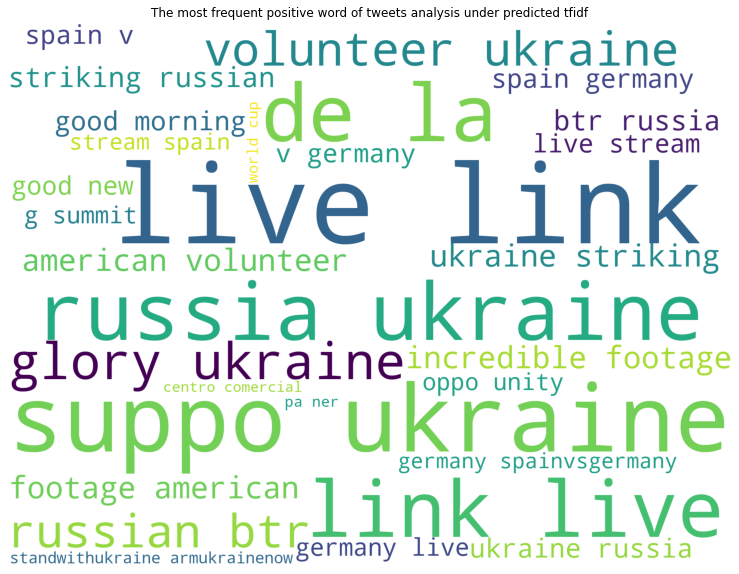

In [ ]:
#wordcloud of tweets analysis under predicted tfidf with positive sentiment
ukraine_fulldf_ca_pos=defaultdict(int)
ukraine_fulldf_pos=ukraine_fulldf[ukraine_fulldf.Pred_tfidf	==1]
word=' '.join(ukraine_fulldf_pos.text)
wc=WordCloud(background_color='white',width=2000, height=1500,max_words=30).generate(word)
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.title('The most frequent positive word of tweets analysis under predicted tfidf')
plt.axis('off')
plt.show()

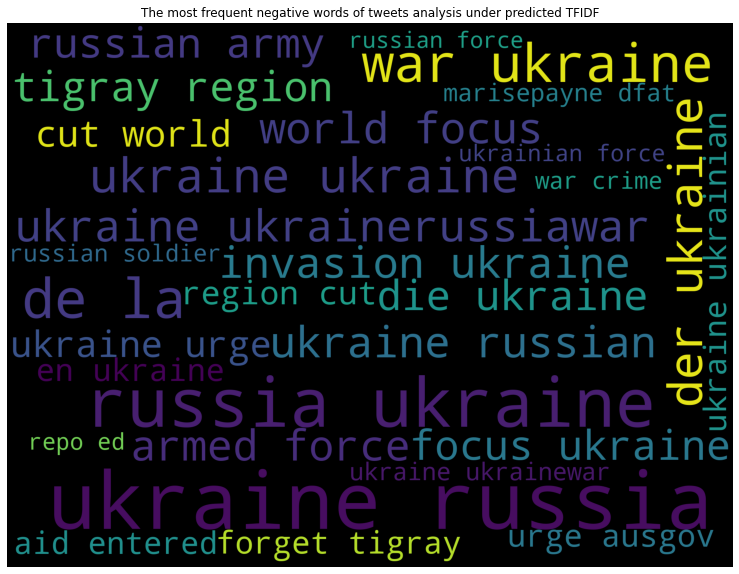

In [ ]:
#wordcloud of tweets analysis under predicted tfidf with negative sentiment
ukraine_fulldf_ca_pos=defaultdict(int)
ukraine_fulldf_neg=ukraine_fulldf[ukraine_fulldf.Pred_tfidf	==0]
word=' '.join(ukraine_fulldf_neg.text)
wc=WordCloud(background_color='black',width=2000, height=1500,max_words=30).generate(word)
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.title('The most frequent negative words of tweets analysis under predicted TFIDF')
plt.axis('off')
plt.show()

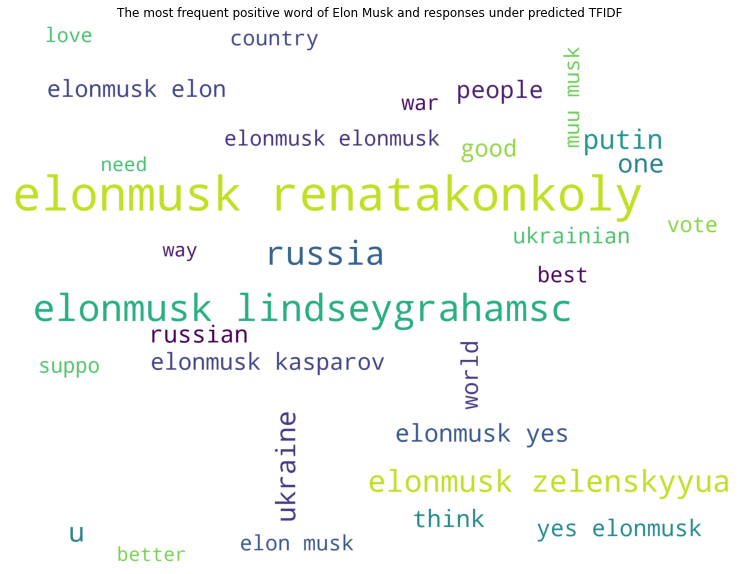

In [ ]:
#wordcloud of tweets of Elon Musk and responses to his tweets under predicted TFIDF with positive sentiment
elon_df_ca_pos=defaultdict(int)
elon_df_pos=elon_df[elon_df.Pred_TFIDF	==1]
word=' '.join(elon_df_pos.text)
wc=WordCloud(background_color='white',width=2000, height=1500,max_words=30).generate(word)
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.title('The most frequent positive word of Elon Musk and responses under predicted TFIDF')
plt.axis('off')
plt.show()

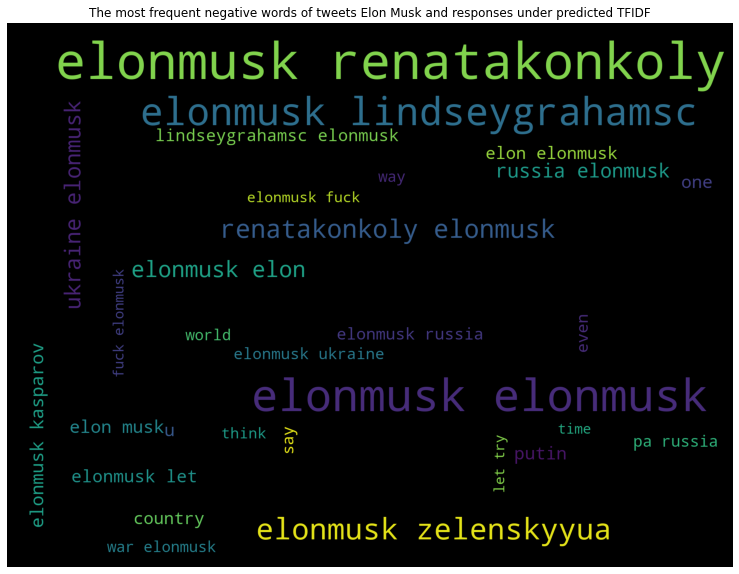

In [ ]:
#wordcloud of tweets of Elon Musk and responses to his tweets under predicted TFIDF with negative sentiment
elon_df_ca_neg=defaultdict(int)
elon_df_neg=elon_df[elon_df.Pred_TFIDF==0]
word=' '.join(elon_df_neg.text)
wc=WordCloud(background_color='black',width=2000, height=1500,max_words=30).generate(word)
plt.figure(figsize=(13, 13))
plt.imshow(wc)
plt.title('The most frequent negative words of tweets Elon Musk and responses under predicted TFIDF')
plt.axis('off')
plt.show()